id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
4586     False
40656    False
26850    False
34095    False
31212    False
         ...  
32178    False
8042     False
1264     False
23493    False
35352    False
Name: stroke, Length: 23257, dtype: bool


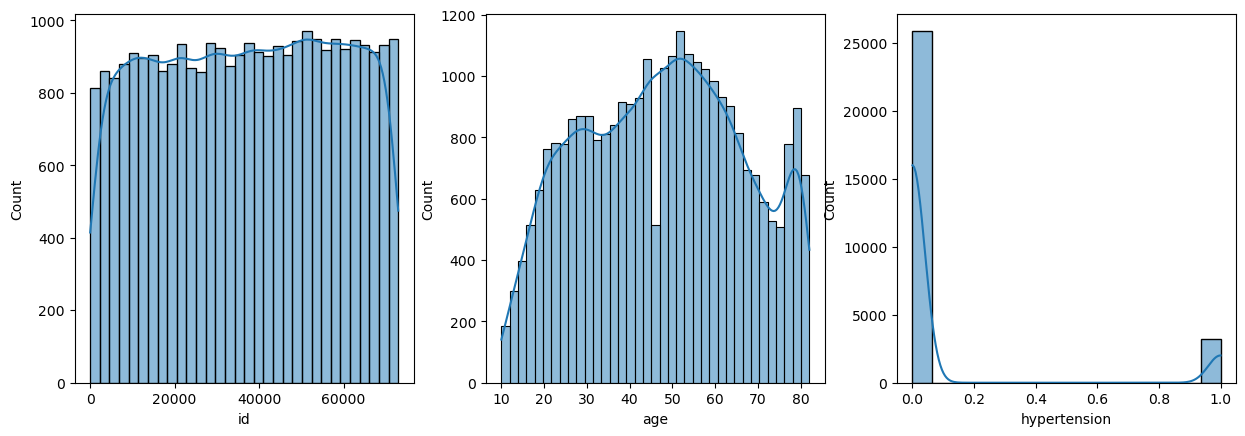

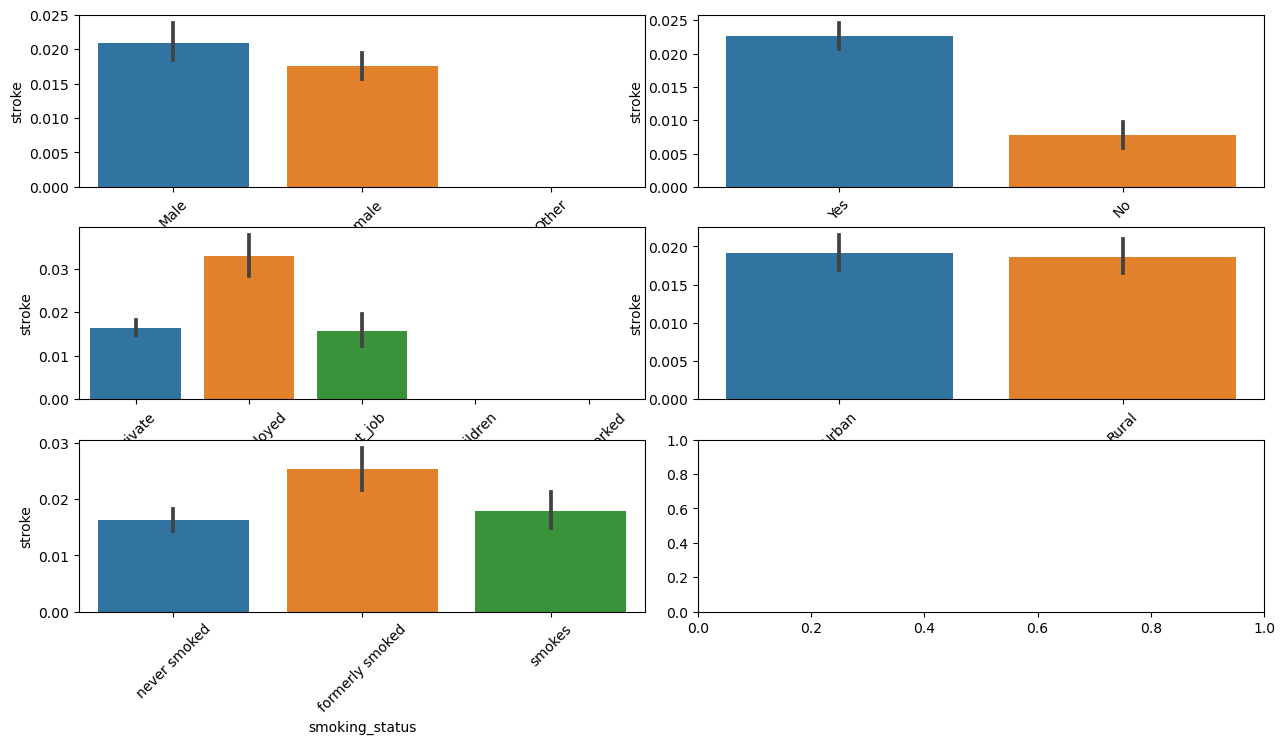

In [1]:
import PySimpleGUI as sg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
import missingno as msno
import io
from PIL import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder


def read_table():
    sg.set_options(auto_size_buttons=True)
    layout = [[sg.Text('Dataset (a CSV file)', size=(16, 1)),sg.InputText(),
               sg.FileBrowse(file_types=(("CSV Files", "*.csv"),("Text Files", "*.txt")))],
               [sg.Submit(), sg.Cancel()]]

    window1 = sg.Window('Input file', layout)
    try:
        event, values = window1.read()
        window1.close()
    except:
        window1.close()
        return
    
    filename = values[0]
    
    if filename == '':
        return

    data = []
    header_list = []

    if filename is not None:
        fn = filename.split('/')[-1]
        try:                     
            if colnames_checked:
                df = pd.read_csv(filename, sep=',', engine='python')
                # Utilise la première ligne (qui devrait être les noms de colonnes) comme noms de colonnes
                header_list = list(df.columns)
               # Supprime la première ligne dans la table (sinon, les noms d'en-tête et la première ligne seront identiques)
                data = df[1:].values.tolist()
            else:
                df = pd.read_csv(filename, sep=',', engine='python', header=None)
                # Crée des noms de colonnes pour chaque colonne ('column0', 'column1', etc)
                header_list = ['column' + str(x) for x in range(len(df.iloc[0]))]
                df.columns = header_list
                # lit tout le reste dans une liste de lignes
                data = df.values.tolist()
            # NaN drop?
            if dropnan_checked:
                df = df.dropna()
                data = df.values.tolist()
            window1.close()
            return (df,data, header_list,fn)
        except:
            sg.popup_error('Error reading file')
            window1.close()
            return

def afficher(data, header_list, fn):    
    layout = [
        [sg.Table(values=data,
                  headings=header_list,
                  font='Helvetica',
                  pad=(25,25),
                  display_row_numbers=False,
                  auto_size_columns=True,
                  num_rows=min(25, len(data)))]
    ]

    window = sg.Window(fn, layout, grab_anywhere=False)
    event, values = window.read()
    window.close()



def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

def visualise(df):
    

    # Plotting histograms pour les variables continues
    num_variables = df.select_dtypes(include='number').columns
    hist_plot = plt.figure(figsize=(20, 5))
    axs = hist_plot.subplots(1, 3)

    for var, subplot in zip(num_variables, axs.flatten()):
        sns.histplot(df[var], kde=True, ax=subplot)

    plt.tight_layout(pad=3)

    # Create a PySimpleGUI window for the histograms
    layout_hist = [
        [sg.Text('Histogramme pour les valeurs continues')],
        [sg.Canvas(key='-CANVAS1-')],
        [sg.Button('Ok')]
    ]

    window_hist = sg.Window('Histograms', layout_hist, finalize=True, element_justification='center', font='Helvetica 18')

    # Add the histograms plot to the window
    fig_canvas_agg = draw_figure(window_hist['-CANVAS1-'].TKCanvas, hist_plot)

    while True:
        event, values = window_hist.read()

        if event in (sg.WIN_CLOSED, 'OK'):
            break

    window_hist.close()

    # Plotting the specified bar plots pour les variables categirelles
    cat_variables = df.select_dtypes(include='object').columns
    bar_plot = plt.figure(figsize=(20, 20))
    axs = bar_plot.subplots(len(cat_variables) // 2 + 1, 2)

    for var, subplot in zip(cat_variables, axs.flatten()):
        if var in df.columns:  # Vérifie si la variable est toujours présente dans le DataFrame
            sns.barplot(x=var, y=varcible, data=df, ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(45)

    plt.tight_layout()

    # Create a PySimpleGUI window for the bar plots
    layout_bar = [
        [sg.Text('Bar Plots pour les données catégorielles')],
        [sg.Canvas(key='-CANVAS2-')],
        [sg.Button('OK')]
    ]

    window_bar = sg.Window('Bar Plots', layout_bar, finalize=True, element_justification='center', font='Helvetica 18')

    # Add the bar plots for categorical variables to the window
    fig_canvas_agg = draw_figure(window_bar['-CANVAS2-'].TKCanvas, bar_plot)

    while True:
        event, values = window_bar.read()

        if event in (sg.WIN_CLOSED, 'OK'):
            break

    window_bar.close()
    

def nettoyer(df):
    # Stocke le nombre des valeurs manquantes par colonne dans une variable
    valeurs_manquantes = df.isnull().sum()

    # 2. Suppression des lignes avec des valeurs manquantes si nécessaire
    seuil_suppression = 0.05
    colonnes_a_supprimer = valeurs_manquantes[valeurs_manquantes / len(df) > seuil_suppression].index
    df = df.drop(colonnes_a_supprimer, axis=1)

    # 3. Imputation des valeurs manquantes
    for colonne in df.columns:
        if df[colonne].dtype == 'float64' or df[colonne].dtype == 'int64':
            # Imputation par la moyenne pour les variables numériques
            df[colonne] = df[colonne].fillna(df[colonne].mean())
        elif df[colonne].dtype == 'object':
            # Imputation par la plus fréquente pour les variables catégoriques
            df[colonne] = df[colonne].fillna(df[colonne].mode().iloc[0])
            # Preprocess categorical variables using LabelEncoder
            label_encoder = LabelEncoder()
            df[colonne] = label_encoder.fit_transform(df[colonne])

    # 4. Recherche des valeurs dupliquées
    df = df.drop_duplicates()

    # 5. Remplacement des 0 et 1 par True et False
    for colonne in df.select_dtypes(include=['int64']).columns:
        if set(df[colonne].unique()) == {0, 1}:
            df[colonne] = df[colonne].replace({0: False, 1: True})

    # 6. Gestion des valeurs aberrantes
    for colonne in df.select_dtypes(include=['float64', 'int64']).columns:
        z_scores = np.abs(stats.zscore(df[colonne]))
        df[colonne] = np.where(z_scores > 3, df[colonne].median(), df[colonne])

    print(df.isnull().sum())
    return df



def splitdata(df, cible, test_size=0.2, random_state=None): #Fonction pour diviser le dataset
    X = df.drop([cible], axis=1)
    y = df[cible]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test
    
  
     
def sklearn_model(varcible): #Application des modeles
    if varcible is None:
        return "Veuillez sélectionner une variable cible."

    results = []

    if y_train.dtype in ['object','bool']:  # Catégorielle
        # Utiliser des modèles de classification
        models = [
            ("Random Forest Classifier", RandomForestClassifier()),
            ("Decision Tree Classifier", DecisionTreeClassifier()),
            ("Logistic Regression", LogisticRegression())
        ]

        for model_name, model in models:
           
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                results.append(f"{model_name}: Précision = {accuracy:.2f}")

            

    elif y_train.dtype in ['float64', 'int64']:  # Numérique
        # Utiliser des modèles de régression
        models = [
            ("Random Forest Regressor", RandomForestRegressor()),
            ("Decision Tree Regressor", DecisionTreeRegressor()),
            ("Linear Regression", LinearRegression())
        ]

        for model_name, model in models:
            
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                results.append(f"{model_name}: MSE = {mse:.2f}")

           
    return results

    
   
    
    


    
    
#=====================================================#
# Define the window's contents 
layout = [
    [sg.Button('Charger les données', size=(17, 1), enable_events=True, key='-LIRE-', font='Helvetica 16'),
     sg.Checkbox('A des noms de colonnes?', size=(15, 1), key='colnames-check', default=True),
     sg.Checkbox('Supprimer les entrées NaN?', size=(15, 1), key='drop-nan', default=True)],

    [sg.Button('Afficher la table', size=(17, 1), enable_events=True, key='-AFFICHER-', font='Helvetica 16'),
     sg.Button('Visualiser', size=(17, 1), enable_events=True, key='-VISUALIZE-', font='Helvetica 16'),
     sg.Button('Nettoyer', size=(10, 1), enable_events=True, key='-NETTOYAGE-', font='Helvetica 16')],
     [sg.Button('Diviser Data',size=(15,1),enable_events=True, key='-SPLIT-', font='Helvetica 16'),
     sg.Button('Appliquer algorithmes',size=(17,1),enable_events=True, key='-ALGO-',font='Helvetica 16')],

    [sg.Text("", size=(50, 1), key='-loaded-', pad=(5, 5), font='Helvetica 14')],
    [sg.Text("Sélectionnez la colonne cible", size=(30, 1), font='Helvetica 12')],
    [sg.Listbox(values=(''), key='colnames', size=(30, 3), enable_events=True)],
    
    [sg.Text("", size=(50, 1), key='-prediction-', pad=(5, 5), font='Helvetica 12')],
    [sg.ProgressBar(50, orientation='h', size=(100, 20), key='progressbar')],
]



# Create the window
window = sg.Window('Application Projet data Mining', layout, size=(600,300))
progress_bar = window['progressbar']
prediction_text = window['-prediction-']
colnames_checked = False
dropnan_checked = False
read_successful = False
# Event loop
while True:
    event, values = window.read()
    loaded_text = window['-loaded-']
    
    
    if event in (sg.WIN_CLOSED, 'Exit'):
        break
    if event == '-LIRE-':
        if values['colnames-check']==True:
            colnames_checked=True
        if values['drop-nan']==True:
            dropnan_checked=True
        try:
            df,data, header_list,fn = read_table()
            
            read_successful = True
        except:
            pass
        if read_successful:
            loaded_text.update("Datset loaded: '{}'".format(fn))
            col_vals = [i for i in df.columns]
            window.Element('colnames').Update(values=col_vals, )
    if event == '-AFFICHER-':
        if read_successful:
            afficher(data,header_list,fn)
        else:
            loaded_text.update("No dataset was loaded")
    if event == 'colnames' and values['colnames']:
        varcible = values['colnames'][0]
        prediction_text.update(f"Colonne cible sélectionnée: '{varcible}'")

   

    if event=='-VISUALIZE-':
        if read_successful:
            visualise(df)
        else:
            loaded_text.update("No dataset was loaded")
    if event=='-NETTOYAGE-':
        if read_successful:
            df=nettoyer(df)
        else:
            loaded_text.update("No dataset was loaded")
    if event=='-SPLIT-':
        if read_successful:
            X_train, X_test, y_train, y_test = splitdata(df, cible=varcible, test_size=0.2, random_state=42)
            print(y_train) #Juste pour tester qu'on a bien diviser le dataset
        else:
            loaded_text.update("No dataset was loaded")
    if event=='-ALGO-':
        if read_successful:
            results = sklearn_model(varcible)
            s = '\n'.join([str(i) for i in results])
            sg.PopupScrolled("Le training a terminé voici les resultats: \n",f"{s}")
        else:
            loaded_text.update("No dataset was loaded")


            
    
    
   
